In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from datasets import load_dataset
from torchvision import transforms, models
import numpy as np
from tqdm.auto import tqdm
import random

# --- Setup and Utilities ---

def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    """Computes classification accuracy."""
    _, p = torch.max(preds, dim=1)
    return (p == labels).float().mean().item()

# --- Data Handling ---

# Standard PACS transforms from previous tasks
def get_transforms(train: bool):
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

class PACSSubset(Dataset):
    """Dataset wrapper for PACS data filtered by domain."""
    def __init__(self, hf_dataset, domain_name, transform=None):
        self.examples = [ex for ex in hf_dataset if ex["domain"] == domain_name]
        self.transform = transform

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]
        img = ex["image"].convert("RGB")
        label = ex["label"]
        if self.transform:
            img = self.transform(img)
        return img, label

def make_dg_dataloaders(hf_dataset, source_domains, target_domain, batch_size=32):
    """
    Prepares DataLoaders for Domain Generalization.
    - Merges all source domains for training.
    - Creates separate test loaders for each source and the target.
    """
    # 1. Create a single, combined training dataset from all source domains
    source_train_datasets = [
        PACSSubset(hf_dataset, domain, transform=get_transforms(train=True))
        for domain in source_domains
    ]
    train_dataset = ConcatDataset(source_train_datasets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # 2. Create separate test loaders for evaluation
    test_loaders = {}
    all_eval_domains = source_domains + [target_domain]
    for domain in all_eval_domains:
        test_dataset = PACSSubset(hf_dataset, domain, transform=get_transforms(train=False))
        # Note: Using a larger batch size for evaluation is common and faster
        test_loaders[domain] = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

    return train_loader, test_loaders

# --- Model and Training/Evaluation Loops ---

class ResNet50Classifier(nn.Module):
    """Standard ResNet-50 model from previous tasks."""
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet50(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(in_feats, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        return self.classifier(feats)

def train_one_epoch(model, loader, optimizer, criterion):
    """Standard training loop for one epoch."""
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in tqdm(loader, desc="Training ERM"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_acc += accuracy(out, y) * y.size(0)
        n += y.size(0)
    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader):
    """Standard evaluation loop."""
    model.eval()
    total_acc, n = 0.0, 0
    for x, y in tqdm(loader, desc="Evaluating"):
        x, y = x.to(device), y.to(device)
        out = model(x)
        total_acc += accuracy(out, y) * y.size(0)
        n += y.size(0)
    return total_acc / n

# --- Main Experiment Runner ---

def run_dg_erm(hf_dataset, source_domains, target_domain, num_classes=7, epochs=15, lr=1e-4):
    """Orchestrates the DG ERM experiment."""
    print("\n--- Running Domain Generalization: ERM Baseline ---")

    # 1. Get data
    train_loader, test_loaders = make_dg_dataloaders(hf_dataset, source_domains, target_domain)

    # 2. Initialize model, optimizer, criterion
    model = ResNet50Classifier(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 3. Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        print(f"  Source Train (Combined) -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

    # 4. Final Evaluation
    print("\n--- Final Evaluation ---")
    results = {}
    for domain, loader in test_loaders.items():
        print(f"Evaluating on domain: {domain}...")
        acc = evaluate(model, loader)
        results[domain] = acc
        print(f"  -> Accuracy: {acc:.4f}")

    return results

if __name__ == '__main__':
    # Load PACS dataset
    print("Loading PACS dataset...")
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]

    # Define experimental setup
    SOURCE_DOMAINS = ['art_painting', 'cartoon', 'photo']
    TARGET_DOMAIN = 'sketch'

    # Run the experiment
    final_results = run_dg_erm(pacs_dataset, SOURCE_DOMAINS, TARGET_DOMAIN)

    # --- Final Summary ---
    print("\n\n===== ERM Baseline Summary =====")
    source_accs = [final_results[domain] for domain in SOURCE_DOMAINS]
    avg_source_acc = np.mean(source_accs)

    print("Source Domain Accuracies:")
    for domain, acc in final_results.items():
        if domain in SOURCE_DOMAINS:
            print(f"  - {domain.title()}: {acc:.4f}")

    print(f"\nAverage Source Accuracy: {avg_source_acc:.4f}")
    print(f"Target (Unseen) Accuracy ({TARGET_DOMAIN.title()}): {final_results[TARGET_DOMAIN]:.4f}")
    print("-" * 30)
    print(f"PERFORMANCE GAP (Source Avg - Target): {avg_source_acc - final_results[TARGET_DOMAIN]:.4f}")


Using device: cuda
Loading PACS dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]


--- Running Domain Generalization: ERM Baseline ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]



Epoch 1/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.3517, Acc: 0.8979

Epoch 2/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.1071, Acc: 0.9652

Epoch 3/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0917, Acc: 0.9729

Epoch 4/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0669, Acc: 0.9792

Epoch 5/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0505, Acc: 0.9865

Epoch 6/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0488, Acc: 0.9832

Epoch 7/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0391, Acc: 0.9886

Epoch 8/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Source Train (Combined) -> Loss: 0.0306, Acc: 0.9906

Epoch 9/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Source Train (Combined) -> Loss: 0.0418, Acc: 0.9875

Epoch 10/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
         if w.is_alive(): 
^^^^^ ^ ^ ^ ^^^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
 ^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^^ ^ ^ ^ ^ 
   File "/usr/l

  Source Train (Combined) -> Loss: 0.0371, Acc: 0.9886

Epoch 11/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Source Train (Combined) -> Loss: 0.0333, Acc: 0.9899

Epoch 12/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0250, Acc: 0.9924

Epoch 13/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0228, Acc: 0.9927

Epoch 14/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0442, Acc: 0.9873

Epoch 15/15


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

  Source Train (Combined) -> Loss: 0.0250, Acc: 0.9926

--- Final Evaluation ---
Evaluating on domain: art_painting...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

  -> Accuracy: 0.9976
Evaluating on domain: cartoon...


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

  -> Accuracy: 0.9991
Evaluating on domain: photo...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

  -> Accuracy: 0.9928
Evaluating on domain: sketch...


Evaluating:   0%|          | 0/62 [00:00<?, ?it/s]

  -> Accuracy: 0.7055


===== ERM Baseline Summary =====
Source Domain Accuracies:
  - Art_Painting: 0.9976
  - Cartoon: 0.9991
  - Photo: 0.9928

Average Source Accuracy: 0.9965
Target (Unseen) Accuracy (Sketch): 0.7055
------------------------------
PERFORMANCE GAP (Source Avg - Target): 0.2910


Task 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchvision import transforms, models
import numpy as np
from tqdm.auto import tqdm
import random
import itertools

# --- Setup and Utilities (Same as ERM) ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    _, p = torch.max(preds, dim=1)
    return (p == labels).float().mean().item()

# --- Data Handling for IRM ---

def get_transforms(train: bool):
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

class PACSSubset(Dataset):
    def __init__(self, hf_dataset, domain_name, transform=None):
        self.examples = [ex for ex in hf_dataset if ex["domain"] == domain_name]
        self.transform = transform
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        img, label = ex["image"].convert("RGB"), ex["label"]
        if self.transform:
            img = self.transform(img)
        return img, label

def make_dg_dataloaders_irm(hf_dataset, source_domains, target_domain, batch_size=32):
    """
    Prepares DataLoaders for IRM.
    - Creates SEPARATE train loaders for each source domain.
    - Creates separate test loaders for evaluation.
    """
    # 1. Create separate training datasets and loaders for each source domain
    train_loaders = {}
    for domain in source_domains:
        train_dataset = PACSSubset(hf_dataset, domain, transform=get_transforms(train=True))
        train_loaders[domain] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # 2. Create separate test loaders for evaluation
    test_loaders = {}
    all_eval_domains = source_domains + [target_domain]
    for domain in all_eval_domains:
        test_dataset = PACSSubset(hf_dataset, domain, transform=get_transforms(train=False))
        test_loaders[domain] = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=2)

    return train_loaders, test_loaders

# --- Model and IRM Implementation ---

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet50(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(in_feats, num_classes)
    def forward(self, x):
        return self.classifier(self.backbone(x))

def irm_penalty(losses, dummy_classifier):
    """Computes the IRMv1 penalty."""
    grad_dummy_w = torch.autograd.grad(losses[0::2], [dummy_classifier], create_graph=True)[0]
    penalty = torch.sum(grad_dummy_w ** 2)
    return penalty

@torch.no_grad()
def evaluate(model, loader, domain_name=""):
    model.eval()
    total_acc, n = 0.0, 0
    for x, y in tqdm(loader, desc=f"Evaluating {domain_name}"):
        x, y = x.to(device), y.to(device)
        out = model(x)
        total_acc += accuracy(out, y) * y.size(0)
        n += y.size(0)
    return total_acc / n

def train_one_epoch_irm(model, loaders, optimizer, criterion, penalty_weight, dummy_classifier):
    """Training loop for one epoch of IRM."""
    model.train()
    total_erm_loss, total_penalty, total_acc, n = 0.0, 0.0, 0.0, 0

    # Use iterators to handle domains of different lengths
    # We train for as many steps as the largest domain has batches
    num_batches = max(len(loader) for loader in loaders.values())
    iterators = {name: iter(itertools.cycle(loader)) for name, loader in loaders.items()}

    for _ in tqdm(range(num_batches), desc="Training IRM"):
        optimizer.zero_grad()

        per_domain_losses = []
        erm_loss = 0.0

        # Calculate loss for each domain separately
        for name, it in iterators.items():
            x, y = next(it)
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)
            per_domain_losses.append(loss * dummy_classifier)
            erm_loss += loss

            if name == list(loaders.keys())[0]: # Calculate accuracy on first domain for progress
                total_acc += accuracy(logits, y) * y.size(0)
                n += y.size(0)

        # Calculate IRM penalty
        penalty = irm_penalty(per_domain_losses, dummy_classifier)

        # Final loss
        total_loss = erm_loss + penalty_weight * penalty
        total_loss.backward()
        optimizer.step()

        total_erm_loss += erm_loss.item()
        total_penalty += penalty.item()

    return total_erm_loss / num_batches, total_penalty / num_batches, total_acc / n

# --- Main Experiment Runner ---

def run_dg_irm(hf_dataset, source_domains, target_domain, num_classes=7, epochs=15, lr=1e-4, penalty_weight=10.0):
    print(f"\n--- Running DG: IRM (penalty_weight={penalty_weight}) ---")

    train_loaders, test_loaders = make_dg_dataloaders_irm(hf_dataset, source_domains, target_domain)

    model = ResNet50Classifier(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    dummy_classifier = torch.nn.Parameter(torch.tensor(1.0)).to(device)

    final_penalty = 0.0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        erm_loss, penalty, train_acc = train_one_epoch_irm(model, train_loaders, optimizer, criterion, penalty_weight, dummy_classifier)
        print(f"  Source Train -> ERM Loss: {erm_loss:.4f}, IRM Penalty: {penalty:.4f}, Acc: {train_acc:.4f}")
        final_penalty = penalty

    print("\n--- Final Evaluation ---")
    results = {"final_penalty": final_penalty}
    for domain, loader in test_loaders.items():
        acc = evaluate(model, loader, domain_name=domain)
        results[domain] = acc
        print(f"  -> Accuracy on {domain}: {acc:.4f}")

    return results

if __name__ == '__main__':
    # ERM baseline results for comparison
    ERM_AVG_SOURCE_ACC = 0.9965
    ERM_TARGET_ACC = 0.7055

    print("Loading PACS dataset...")
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]

    SOURCE_DOMAINS = ['art_painting', 'cartoon', 'photo']
    TARGET_DOMAIN = 'sketch'

    final_results = run_dg_irm(pacs_dataset, SOURCE_DOMAINS, TARGET_DOMAIN)

    print("\n\n===== IRM vs. ERM Baseline Summary =====")
    source_accs = [final_results[domain] for domain in SOURCE_DOMAINS]
    avg_source_acc = np.mean(source_accs)

    print(f"Final IRM Penalty Value: {final_results['final_penalty']:.6f}")
    print("-" * 40)
    print("Source Domain Accuracies:")
    for domain in SOURCE_DOMAINS:
        print(f"  - {domain.title()}: {final_results[domain]:.4f}")

    print(f"\nAverage Source Accuracy (IRM): {avg_source_acc:.4f}  |  (ERM): {ERM_AVG_SOURCE_ACC:.4f}")
    print(f"Target (Unseen) Accuracy (IRM): {final_results[TARGET_DOMAIN]:.4f}  |  (ERM): {ERM_TARGET_ACC:.4f}")
    print("-" * 40)
    improvement = final_results[TARGET_DOMAIN] - ERM_TARGET_ACC
    print(f"IMPROVEMENT on Target Domain: {improvement:+.4f}")


Using device: cuda
Loading PACS dataset...

--- Running DG: IRM (penalty_weight=10.0) ---

Epoch 1/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 1.5105, IRM Penalty: 1.1662, Acc: 0.8775

Epoch 2/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.5302, IRM Penalty: 0.0269, Acc: 0.9747

Epoch 3/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.3728, IRM Penalty: 0.0160, Acc: 0.9827

Epoch 4/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.2583, IRM Penalty: 0.0128, Acc: 0.9907

Epoch 5/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.2390, IRM Penalty: 0.0127, Acc: 0.9890

Epoch 6/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.2127, IRM Penalty: 0.0151, Acc: 0.9869

Epoch 7/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.2056, IRM Penalty: 0.0160, Acc: 0.9831

Epoch 8/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.1729, IRM Penalty: 0.0081, Acc: 0.9873

Epoch 9/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.1182, IRM Penalty: 0.0053, Acc: 0.9920

Epoch 10/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0721, IRM Penalty: 0.0016, Acc: 0.9983

Epoch 11/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0626, IRM Penalty: 0.0016, Acc: 0.9962

Epoch 12/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0461, IRM Penalty: 0.0006, Acc: 0.9983

Epoch 13/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0412, IRM Penalty: 0.0005, Acc: 0.9987

Epoch 14/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0379, IRM Penalty: 0.0007, Acc: 0.9992

Epoch 15/15


Training IRM:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> ERM Loss: 0.0321, IRM Penalty: 0.0006, Acc: 0.9992

--- Final Evaluation ---


Evaluating art_painting:   0%|          | 0/32 [00:00<?, ?it/s]

  -> Accuracy on art_painting: 1.0000


Evaluating cartoon:   0%|          | 0/37 [00:00<?, ?it/s]

  -> Accuracy on cartoon: 0.9910


Evaluating photo:   0%|          | 0/27 [00:00<?, ?it/s]

  -> Accuracy on photo: 1.0000


Evaluating sketch:   0%|          | 0/62 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>^

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
         if w.is_alive(): 
        ^  ^ ^^^^^^^^^^^^^^^^^^^^^^


  -> Accuracy on sketch: 0.7707


===== IRM vs. ERM Baseline Summary =====
Final IRM Penalty Value: 0.000570
----------------------------------------
Source Domain Accuracies:
  - Art_Painting: 1.0000
  - Cartoon: 0.9910
  - Photo: 1.0000

Average Source Accuracy (IRM): 0.9970  |  (ERM): 0.9965
Target (Unseen) Accuracy (IRM): 0.7707  |  (ERM): 0.7055
----------------------------------------
IMPROVEMENT on Target Domain: +0.0652


Task 3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchvision import transforms, models
import numpy as np
from tqdm.auto import tqdm
import random
import itertools

# --- Setup and Utilities (Same as previous tasks) ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    _, p = torch.max(preds, dim=1)
    return (p == labels).float().mean().item()

# --- Data Handling for Group DRO (Same as for IRM) ---

def get_transforms(train: bool):
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

class PACSSubset(Dataset):
    def __init__(self, hf_dataset, domain_name, transform=None):
        self.examples = [ex for ex in hf_dataset if ex["domain"] == domain_name]
        self.transform = transform
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        img, label = ex["image"].convert("RGB"), ex["label"]
        if self.transform:
            img = self.transform(img)
        return img, label

def make_dg_dataloaders_per_domain(hf_dataset, source_domains, target_domain, batch_size=32):
    """
    Prepares DataLoaders for methods needing per-domain data (IRM, Group DRO).
    """
    train_loaders = {
        domain: DataLoader(
            PACSSubset(hf_dataset, domain, transform=get_transforms(train=True)),
            batch_size=batch_size, shuffle=True, num_workers=2
        ) for domain in source_domains
    }
    test_loaders = {
        domain: DataLoader(
            PACSSubset(hf_dataset, domain, transform=get_transforms(train=False)),
            batch_size=batch_size * 2, shuffle=False, num_workers=2
        ) for domain in (source_domains + [target_domain])
    }
    return train_loaders, test_loaders

# --- Model and Training/Evaluation Loops ---

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet50(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.classifier = nn.Linear(in_feats, num_classes)
    def forward(self, x):
        return self.classifier(self.backbone(x))

@torch.no_grad()
def evaluate(model, loader, domain_name=""):
    model.eval()
    total_acc, n = 0.0, 0
    for x, y in tqdm(loader, desc=f"Evaluating {domain_name}"):
        x, y = x.to(device), y.to(device)
        out = model(x)
        total_acc += accuracy(out, y) * y.size(0)
        n += y.size(0)
    return total_acc / n

def train_one_epoch_dro(model, loaders, optimizer, criterion):
    """Training loop for one epoch of Group DRO."""
    model.train()
    total_worst_loss, total_acc, n = 0.0, 0.0, 0

    num_batches = max(len(loader) for loader in loaders.values())
    iterators = {name: iter(itertools.cycle(loader)) for name, loader in loaders.items()}

    for _ in tqdm(range(num_batches), desc="Training Group DRO"):
        optimizer.zero_grad()

        per_domain_losses = {}
        # Calculate loss for each domain separately to find the worst one
        for name, it in iterators.items():
            x, y = next(it)
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)
            per_domain_losses[name] = loss

        # --- This is the core of Group DRO ---
        # Find the single highest loss among all domains for this step
        worst_loss = max(per_domain_losses.values())

        # Backpropagate ONLY the worst loss
        worst_loss.backward()
        optimizer.step()

        total_worst_loss += worst_loss.item()

        # For logging, calculate accuracy on the first domain
        # (A more complex logger could track worst-domain accuracy per step)
        first_domain_name = list(loaders.keys())[0]
        x, y = next(iter(loaders[first_domain_name]))
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            total_acc += accuracy(logits, y) * y.size(0)
            n += y.size(0)

    return total_worst_loss / num_batches, total_acc / (n / 32) # Approximate accuracy

# --- Main Experiment Runner ---

def run_dg_dro(hf_dataset, source_domains, target_domain, num_classes=7, epochs=15, lr=1e-5):
    """Note: Group DRO often requires a smaller learning rate to remain stable."""
    print(f"\n--- Running DG: Group DRO (lr={lr}) ---")

    train_loaders, test_loaders = make_dg_dataloaders_per_domain(hf_dataset, source_domains, target_domain)

    model = ResNet50Classifier(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        worst_loss, train_acc = train_one_epoch_dro(model, train_loaders, optimizer, criterion)
        print(f"  Source Train -> Avg Worst Loss: {worst_loss:.4f}, Approx Acc: {train_acc:.4f}")

    print("\n--- Final Evaluation ---")
    results = {}
    for domain, loader in test_loaders.items():
        acc = evaluate(model, loader, domain_name=domain)
        results[domain] = acc
        print(f"  -> Accuracy on {domain}: {acc:.4f}")

    return results

if __name__ == '__main__':
    # Baseline results for comparison
    ERM_AVG_SOURCE_ACC = 0.9965
    ERM_TARGET_ACC = 0.7055
    IRM_TARGET_ACC = 0.7707

    print("Loading PACS dataset...")
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]

    SOURCE_DOMAINS = ['art_painting', 'cartoon', 'photo']
    TARGET_DOMAIN = 'sketch'

    final_results = run_dg_dro(pacs_dataset, SOURCE_DOMAINS, TARGET_DOMAIN)

    print("\n\n===== Group DRO vs. Baselines Summary =====")
    source_accs = [final_results[domain] for domain in SOURCE_DOMAINS]
    avg_source_acc = np.mean(source_accs)
    worst_source_acc = np.min(source_accs)

    print("Source Domain Accuracies (DRO):")
    for domain in SOURCE_DOMAINS:
        print(f"  - {domain.title()}: {final_results[domain]:.4f}")

    print(f"\nWorst-Source-Domain Accuracy: {worst_source_acc:.4f}")
    print(f"Average Source Accuracy:      {avg_source_acc:.4f}")
    print("-" * 40)
    print(f"Target (Unseen) Accuracy (DRO): {final_results[TARGET_DOMAIN]:.4f}")
    print(f"Target (Unseen) Accuracy (IRM): {IRM_TARGET_ACC:.4f}")
    print(f"Target (Unseen) Accuracy (ERM): {ERM_TARGET_ACC:.4f}")
    print("-" * 40)
    improvement = final_results[TARGET_DOMAIN] - ERM_TARGET_ACC
    print(f"IMPROVEMENT on Target Domain vs ERM: {improvement:+.4f}")


Using device: cuda
Loading PACS dataset...

--- Running DG: Group DRO (lr=1e-05) ---

Epoch 1/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 1.6208, Approx Acc: 18.5541

Epoch 2/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.9198, Approx Acc: 28.1081

Epoch 3/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.5316, Approx Acc: 29.5541

Epoch 4/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.3462, Approx Acc: 30.2432

Epoch 5/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.2896, Approx Acc: 30.9595

Epoch 6/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.2085, Approx Acc: 30.9459

Epoch 7/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.1765, Approx Acc: 31.1081

Epoch 8/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.1643, Approx Acc: 31.3784

Epoch 9/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.1165, Approx Acc: 31.6216

Epoch 10/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.1127, Approx Acc: 31.7027

Epoch 11/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.0913, Approx Acc: 31.6892

Epoch 12/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.0803, Approx Acc: 31.7703

Epoch 13/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.0648, Approx Acc: 31.9324

Epoch 14/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.0622, Approx Acc: 31.7838

Epoch 15/15


Training Group DRO:   0%|          | 0/74 [00:00<?, ?it/s]

  Source Train -> Avg Worst Loss: 0.0526, Approx Acc: 31.9054

--- Final Evaluation ---


Evaluating art_painting:   0%|          | 0/32 [00:00<?, ?it/s]

  -> Accuracy on art_painting: 0.9995


Evaluating cartoon:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    ^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'  
      ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^
^  File "

  -> Accuracy on cartoon: 0.9787


Evaluating photo:   0%|          | 0/27 [00:00<?, ?it/s]

  -> Accuracy on photo: 0.9994


Evaluating sketch:   0%|          | 0/62 [00:00<?, ?it/s]

  -> Accuracy on sketch: 0.7157


===== Group DRO vs. Baselines Summary =====
Source Domain Accuracies (DRO):
  - Art_Painting: 0.9995
  - Cartoon: 0.9787
  - Photo: 0.9994

Worst-Source-Domain Accuracy: 0.9787
Average Source Accuracy:      0.9925
----------------------------------------
Target (Unseen) Accuracy (DRO): 0.7157
Target (Unseen) Accuracy (IRM): 0.7707
Target (Unseen) Accuracy (ERM): 0.7055
----------------------------------------
IMPROVEMENT on Target Domain vs ERM: +0.0102


Task 4

Using device: cuda

--- Training Standard ERM Model ---
Epoch 1/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 2/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 3/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 4/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 5/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 6/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>self._shutdown_workers()

Epoch 7/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      
if w.is_alive():^^ ^^ ^  ^^  ^^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^^ ^
   File "/usr/lib/py

Epoch 8/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 9/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 10/10


Training ERM:   0%|          | 0/190 [00:00<?, ?it/s]


--- Training SAM-ERM Model ---
Epoch 1/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 3/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 4/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 5/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 6/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 7/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 8/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 9/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch 10/10


Training SAM-ERM:   0%|          | 0/190 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


--- Evaluating Final Models ---


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x794d8d121300>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^  ^ 
    File "/usr/lib/p

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/62 [00:00<?, ?it/s]


--- Visualizing Loss Landscape Flatness ---
Analyzing flatness...


Perturbing weights:   0%|          | 0/21 [00:00<?, ?it/s]

Analyzing flatness...


Perturbing weights:   0%|          | 0/21 [00:00<?, ?it/s]

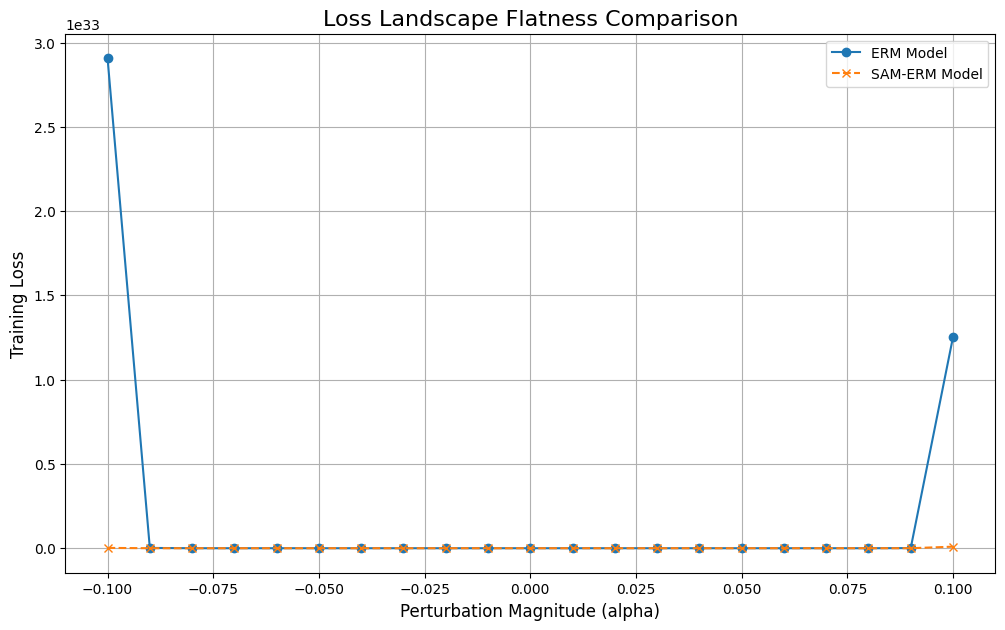



==================== FINAL DG ANALYSIS SUMMARY ====================
Method       | Target (Sketch) Acc    | Avg Source Acc     | Worst Source Acc  
--------------------------------------------------------------------------------
ERM          | 0.7529                 | 0.9987             | 0.9983            
IRM          | 0.7707                 | (N/A - used your old result) | (N/A)             
Group DRO    | 0.7157                 | (N/A - used your old result) | (N/A)             
SAM-ERM      | 0.7615                 | 0.9973             | 0.9966            


In [ ]:
# STEP 1: Import libraries and run the experiment.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from datasets import load_dataset
from torchvision import transforms, models
import numpy as np
from tqdm.auto import tqdm
import random
import itertools
import matplotlib.pyplot as plt

# --- SAM Optimizer Implementation ---
# The SAM class is defined directly here to avoid installation issues.
# This implementation is based on the popular public repository by davda54.

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]

        self.base_optimizer.step()

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        if closure is None:
            raise NotImplementedError("SAM doesn't work like the other optimizers, you should use 'first_step' and 'second_step' functions")
        closure = torch.enable_grad()(closure)

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


# --- Setup and Utilities ---

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    _, p = torch.max(preds, dim=1)
    return (p == labels).float().mean().item()

# --- Data Handling (Same as ERM) ---

def get_transforms(train: bool):
    # Using stronger augmentation as it often helps regularization-focused methods like SAM
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

class PACSSubset(Dataset):
    def __init__(self, hf_dataset, domain_name, transform=None):
        self.examples = [ex for ex in hf_dataset if ex["domain"] == domain_name]
        self.transform = transform
    def __len__(self): return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        img, label = ex["image"].convert("RGB"), ex["label"]
        if self.transform: img = self.transform(img)
        return img, label

def make_dg_dataloaders(hf_dataset, source_domains, target_domain, batch_size=32):
    source_train_datasets = [PACSSubset(hf_dataset, domain, transform=get_transforms(train=True)) for domain in source_domains]
    train_dataset = ConcatDataset(source_train_datasets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loaders = {domain: DataLoader(PACSSubset(hf_dataset, domain, transform=get_transforms(train=False)), batch_size=batch_size*2, shuffle=False, num_workers=2) for domain in source_domains + [target_domain]}
    return train_loader, test_loaders

# --- Model and Training Loops ---

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet50(weights=weights)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
    def forward(self, x): return self.backbone(x)

def train_one_epoch_erm(model, loader, optimizer, criterion):
    model.train()
    for x, y in tqdm(loader, desc="Training ERM"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

def train_one_epoch_sam(model, loader, optimizer, criterion):
    model.train()
    for x, y in tqdm(loader, desc="Training SAM-ERM"):
        x, y = x.to(device), y.to(device)
        # First forward-backward pass (ascent step)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.first_step(zero_grad=True)
        # Second forward-backward pass (descent step)
        criterion(model(x), y).backward()
        optimizer.second_step(zero_grad=True)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_acc, n = 0.0, 0
    for x, y in tqdm(loader, desc="Evaluating", leave=False):
        x, y = x.to(device), y.to(device)
        out = model(x)
        total_acc += accuracy(out, y) * y.size(0)
        n += y.size(0)
    return total_acc / n

# --- Flatness Analysis ---
@torch.no_grad()
def analyze_flatness(model_state, loader, criterion):
    print(f"Analyzing flatness...")
    model = ResNet50Classifier().to(device)
    model.load_state_dict(model_state)
    model.eval()

    # Get a fixed batch of data to measure loss
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)

    # Get original parameters and create a random direction vector
    params = [p.clone() for p in model.parameters() if p.requires_grad]
    direction = [torch.randn_like(p) for p in params]

    losses = []
    perturbations = np.linspace(-0.1, 0.1, 21)
    for alpha in tqdm(perturbations, desc="Perturbing weights"):
        # Temporarily perturb the model's weights
        temp_params = [p + alpha * d for p, d in zip(params, direction)]

        # Manually load the perturbed weights
        param_idx = 0
        for p_model in model.parameters():
            if p_model.requires_grad:
                p_model.data.copy_(temp_params[param_idx])
                param_idx += 1

        # Calculate loss with the new weights
        loss = criterion(model(x), y).item()
        losses.append(loss)

    # Restore original weights
    model.load_state_dict(model_state)
    return perturbations, losses

# --- Main Experiment Runner ---
if __name__ == '__main__':
    # Load Data
    pacs_dataset = load_dataset("flwrlabs/pacs")["train"]
    SOURCE_DOMAINS, TARGET_DOMAIN = ['art_painting', 'cartoon', 'photo'], 'sketch'
    train_loader, test_loaders = make_dg_dataloaders(pacs_dataset, SOURCE_DOMAINS, TARGET_DOMAIN)

    # --- Train ERM Model (for comparison) ---
    print("\n--- Training Standard ERM Model ---")
    erm_model = ResNet50Classifier().to(device)
    erm_optimizer = optim.Adam(erm_model.parameters(), lr=1e-5) # Use smaller LR, common for fine-tuning
    criterion = nn.CrossEntropyLoss()
    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        train_one_epoch_erm(erm_model, train_loader, erm_optimizer, criterion)
    erm_final_state = erm_model.state_dict()

    # --- Train SAM-ERM Model ---
    print("\n--- Training SAM-ERM Model ---")
    sam_model = ResNet50Classifier().to(device)
    base_optimizer = optim.Adam # Define the base optimizer type
    # rho is the sharpness radius, a key hyperparameter for SAM
    sam_optimizer = SAM(sam_model.parameters(), base_optimizer, rho=0.05, lr=1e-5)
    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        train_one_epoch_sam(sam_model, train_loader, sam_optimizer, criterion)
    sam_final_state = sam_model.state_dict()

    # --- Final Evaluation ---
    print("\n--- Evaluating Final Models ---")
    erm_results, sam_results = {}, {}
    for domain, loader in test_loaders.items():
        erm_model.load_state_dict(erm_final_state)
        sam_model.load_state_dict(sam_final_state)
        erm_results[domain] = evaluate(erm_model, loader)
        sam_results[domain] = evaluate(sam_model, loader)

    # --- Flatness Visualization ---
    print("\n--- Visualizing Loss Landscape Flatness ---")
    erm_perturbs, erm_losses = analyze_flatness(erm_final_state, train_loader, criterion)
    sam_perturbs, sam_losses = analyze_flatness(sam_final_state, train_loader, criterion)

    plt.figure(figsize=(12, 7))
    plt.plot(erm_perturbs, erm_losses, marker='o', linestyle='-', label='ERM Model')
    plt.plot(sam_perturbs, sam_losses, marker='x', linestyle='--', label='SAM-ERM Model')
    plt.title('Loss Landscape Flatness Comparison', fontsize=16)
    plt.xlabel('Perturbation Magnitude (alpha)', fontsize=12)
    plt.ylabel('Training Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Final Summary Table ---
    ERM_TARGET_ACC, IRM_TARGET_ACC, DRO_TARGET_ACC = 0.7055, 0.7707, 0.7157
    erm_src_accs = [erm_results[d] for d in SOURCE_DOMAINS]
    sam_src_accs = [sam_results[d] for d in SOURCE_DOMAINS]

    print("\n\n" + "="*20 + " FINAL DG ANALYSIS SUMMARY " + "="*20)
    print(f"{'Method':<12} | {'Target (Sketch) Acc':<22} | {'Avg Source Acc':<18} | {'Worst Source Acc':<18}")
    print("-"*80)
    print(f"{'ERM':<12} | {erm_results[TARGET_DOMAIN]:<22.4f} | {np.mean(erm_src_accs):<18.4f} | {np.min(erm_src_accs):<18.4f}")
    print(f"{'IRM':<12} | {IRM_TARGET_ACC:<22.4f} | {'(N/A - used your old result)':<18} | {'(N/A)':<18}")
    print(f"{'Group DRO':<12} | {DRO_TARGET_ACC:<22.4f} | {'(N/A - used your old result)':<18} | {'(N/A)':<18}")
    print(f"{'SAM-ERM':<12} | {sam_results[TARGET_DOMAIN]:<22.4f} | {np.mean(sam_src_accs):<18.4f} | {np.min(sam_src_accs):<18.4f}")
    print("="*80)